# **FORWARD MODEL OF VEHICLE LATERAL DYNAMICS**

### Import packages

In [1]:
# Import necessary packages
import sys, os
import pandas as pd

# import nnodely modules
from nnodely import *
from nnodely.support.utils import *
from nnodely.support import earlystopping
from nnodely.support.earlystopping import select_best_model

# import a library for plots
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
plt.close('all')
SMALL_SIZE = 14
MEDIUM_SIZE = 22
BIGGER_SIZE = 26
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle="--", color='grey')

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>-- nnodely_v1.5.2 --<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


### Configurations

In [2]:
path_folder = 'trained_models'   # folder to save the model
lat_dyna_model = nnodely(visualizer=MPLNotebookVisualizer(),seed=1,workspace=path_folder,save_history=False)

### Neural Network model

### Model definition

In [3]:
# ----------------------------------------------------------------
# Inputs
# ----------------------------------------------------------------
curv_in  = Input('model_curv_in')    # [1/m] path curvature
vx_in    = Input('model_vx_in')      # [m/s] longitudinal velocity
steer_in = Input('model_steer_in')   # [rad] steering wheel angle
ax_in    = Input('model_ax_in')      # [m/s^2] lateral acceleration

# ----------------------------------------------------------------
# Hyperparameters
# ----------------------------------------------------------------
samples_past_steer = 30  # number of samples in the past for the steering wheel angle prediction
n_channels_vx = 8        # number of channels for activation function vx
chan_vx =  list(np.linspace(8, 23, num=n_channels_vx)) # centers of the channels vx
chan_ax = [-2,-1,0.0,1.0,2.0]   # centers of the channels ax

# Exponential weights for normalisation of FIR parameters during training
W_fir = np.array([[np.exp(-(i/(samples_past_steer/2))**2)] for i in range(-samples_past_steer+1,1)])
W_constant = Constant('W_fir',sw=30, values=W_fir)

# ----------------------------------------------------------------
# Understeer correction function
# ----------------------------------------------------------------
def understeer_corr_local(vx,  # input
                          A    # learnable parameter
                          ):
    return 1 / (1 + A * torch.pow(vx, 2))

understeer_corr = ParamFun(understeer_corr_local)

# ----------------------------------------------------------------
# Local models
# ----------------------------------------------------------------
# Activation functions
fuzzy_vx = Fuzzify(centers=chan_vx, functions='Triangular')(vx_in.last())
fuzzy_ax = Fuzzify(centers=chan_ax, functions='Triangular')(ax_in.last())

# FIR input functions
def Input_Function_Gen(idx):
    def fir_out(fir_input):
        out = Fir(W_init='init_constant', W_init_params={"value": 1}, dropout=0.05, W=f'Fir_{idx[0]}')(fir_input)
        return out

    return fir_out

local_input_model = LocalModel(pass_indexes=True, input_function=Input_Function_Gen)
out_input_model = local_input_model((steer_in.sw(samples_past_steer)  * W_constant ), fuzzy_vx)

# Parametric functions: Understeer correction
def Understeer_Function_Gen(idx):
    def osus_out(vx_input):
        A = Parameter('A_' + str(idx[0]), values=[[1e-5]])
        return understeer_corr(vx_input, A)
    return osus_out

local_osus_corr = LocalModel(pass_indexes=True, input_function=Understeer_Function_Gen)
out_osus = local_osus_corr(vx_in.last(), fuzzy_ax)

# ----------------------------------------------------------------
# Outputs
# ----------------------------------------------------------------
curv_out = Output('model_curv', out_input_model*out_osus)  # output of the model

# ----------------------------------------------------------------
# Add model
# ----------------------------------------------------------------
lat_dyna_model.addModel('vehicle_model', curv_out)

### Loss functions definitions

In [4]:
# ------------------------------------------------------------------------
# Targets
# ------------------------------------------------------------------------
# Definition of heading as integral of curvature multiplied by the longitudinal speed
heading_target = Integrate(curv_in.next()*vx_in.next())
heading_nn     = Integrate(out_input_model*out_osus*vx_in.next())

# Add a loss function: mean squared error for the curvature prediction
lat_dyna_model.addMinimize('curv_error',
                         curv_in.next(),
                         curv_out,
                         loss_function='mse')
# Add a loss function: mean squared error for the heading prediction
lat_dyna_model.addMinimize('heading_error',
                           heading_target,
                           heading_nn)

### Model neuralization

In [5]:
# Generate the model
lat_dyna_model.neuralizeModel(sample_time=0.05)  # neuralize the model with the chosen sample time

[neuralizeModel] Closed loop on Mul87_int34 with sample in the future.
[neuralizeModel] Closed loop on Mul77_int33 with sample in the future.
================================ nnodely Model =================================
{'Constants': {'SampleTime': {'dim': 1, 'values': 0.05},
               'W_fir': {'dim': 1,
                         'sw': 30,
                         'values': [[0.023806948214769363],
                                    [0.03067079372704029],
                                    [0.039163894951343536],
                                    [0.04956628382205963],
                                    [0.062176525592803955],
                                    [0.07730474323034286],
                                    [0.09526325762271881],
                                    [0.116354800760746],
                                    [0.14085842669010162],
                                    [0.16901332139968872],
                                    [0.20100119709968567],


# Training

### Dataset Load

In [6]:
lat_dyna_model.loadData('training_set', source='dataset/training',
                        format=['', 'model_ax_in', '', 'model_vx_in', 'model_curv_in', '', '', 'model_steer_in', ''],
                        skiplines=1)
lat_dyna_model.loadData('validation_set', source='dataset/validation',
                        format=['', 'model_ax_in', '', 'model_vx_in', 'model_curv_in', '', '', 'model_steer_in', ''],
                        skiplines=1)
lat_dyna_model.loadData('test_set', source='dataset/test',
                        format=['', 'model_ax_in', '','model_vx_in', 'model_curv_in', 'model_steer_in'], skiplines=1)

============================ nnodely Model Dataset =============================
Dataset Name:                 training_set
Number of files:              4
Total number of samples:      12212
Shape of model_vx_in:         (12212, 2, 1)
Shape of model_ax_in:         (12212, 1, 1)
Shape of model_steer_in:      (12212, 30, 1)
Shape of model_curv_in:       (12212, 1, 1)
============================ nnodely Model Dataset =============================
Dataset Name:                 validation_set
Number of files:              2
Total number of samples:      5616
Shape of model_vx_in:         (5616, 2, 1)
Shape of model_ax_in:         (5616, 1, 1)
Shape of model_steer_in:      (5616, 30, 1)
Shape of model_curv_in:       (5616, 1, 1)
============================ nnodely Model Dataset =============================
Dataset Name:                 test_set
Number of files:              1
Total number of samples:      1075
Shape of model_vx_in:         (1075, 2, 1)
Shape of model_ax_in:         (1075

### Training

In [7]:
# Default training parameters definition
training_pars = {   'num_of_epochs': 50,
                    'val_batch_size': 64,
                     'train_batch_size': 16,
                     'lr': 1e-3 ,
                    'train_dataset': 'training_set',
                    'validation_dataset': 'validation_set',
                    'optimizer': 'Adam',
                    'shuffle_data': True,
                    'select_model': select_best_model,
                    'early_stopping': earlystopping.early_stop_patience,
                    'early_stopping_params': {'patience': 5,'error': 'heading_error'}}

======================== nnodely Model Train Parameters ========================
models:                       ['vehicle_model']
num of epochs:                50
update per epochs:            763
└>len(train_indexes)//(batch_size+step)
shuffle data:                 True
early stopping:               early_stop_patience
early stopping params:        {'error': 'heading_error', 'patience': 5}
prediction samples:           0
step:                         0
closed loop:                  {}
connect:                      {}
train dataset:                training_set
	- batch size:                16
	- num of samples:            12212
	- num of first samples:      12212
validation dataset:           validation_set
	- batch size:                64
	- num of samples:            5616
	- num of first samples:      5616
minimizers:                   {'curv_error': {'A': 'SamplePart95',
                                              'B': 'Mul72',
                                              'loss': 

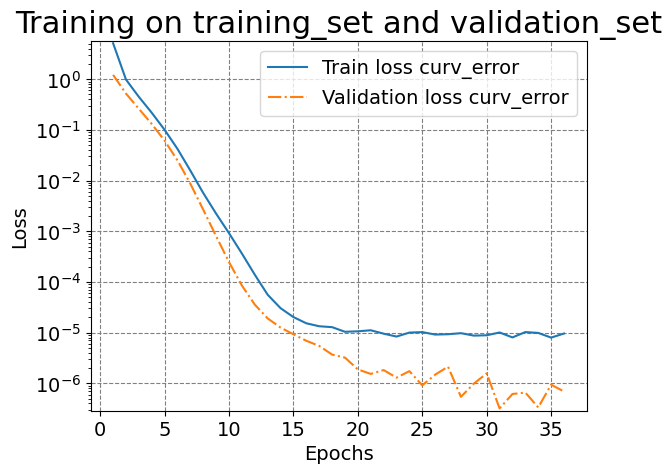

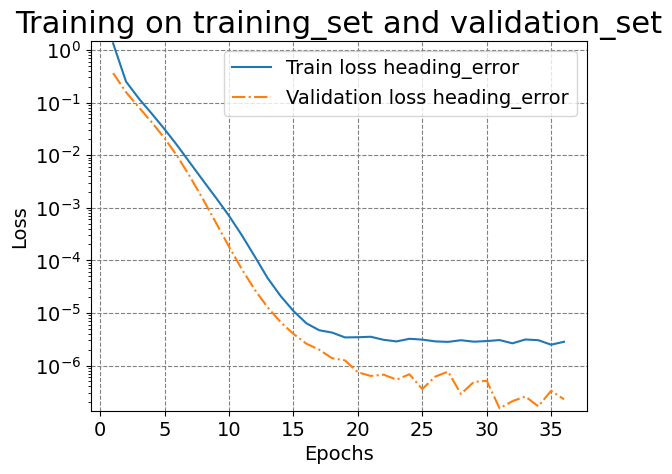

Selected the model at the epoch 31.


In [8]:
# First training without samples in the future
lat_dyna_model.trainModel(training_params=training_pars)

======================== nnodely Model Train Parameters ========================
models:                       ['vehicle_model']
num of epochs:                20
update per epochs:            457
└>len(train_indexes)//(batch_size+step)
shuffle data:                 True
early stopping:               early_stop_patience
early stopping params:        {'error': 'heading_error', 'patience': 5}
prediction samples:           80
step:                         10
closed loop:                  {}
connect:                      {}
train dataset:                training_set
	- batch size:                16
	- num of samples:            12212
	- num of first samples:      11892
validation dataset:           validation_set
	- batch size:                64
	- num of samples:            5616
	- num of first samples:      5456
minimizers:                   {'curv_error': {'A': 'SamplePart95',
                                              'B': 'Mul72',
                                              'loss'

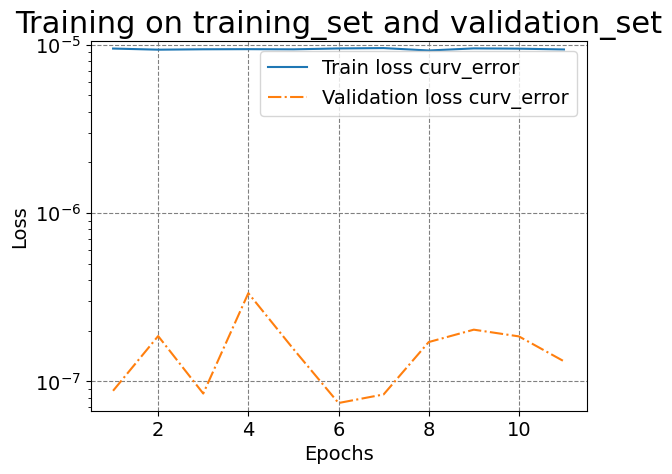

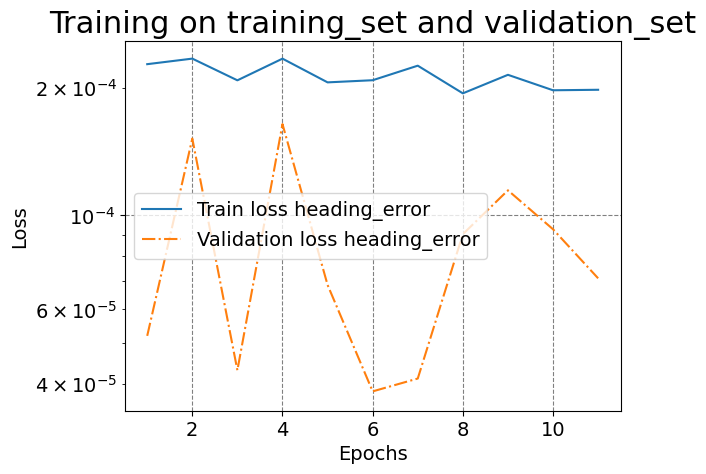

Selected the model at the epoch 6.


In [9]:
# Training with intergal error 4s in the future
lat_dyna_model.trainModel(training_params=training_pars,
                          num_of_epochs=20,
                          prediction_samples=80,   # 4s in the future
                          step=10)

# ANALYZE MODEL

### FIR filters weights

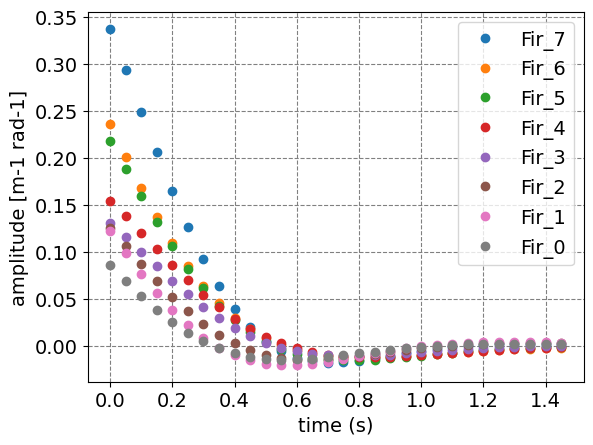

In [10]:
params_fir = {}
sampling_time = 0.05

# Plot
plt.figure()

for key, value in lat_dyna_model.parameters.items():
    if key.startswith('Fir_'):
        params_fir[key] = lat_dyna_model.parameters[key]

for key, value in params_fir.items():
    vals = np.array(value).flatten()
    t = np.arange(0, sampling_time * len(vals), sampling_time)
    plt.plot(t,np.flip(vals * W_fir.flatten()), 'o', label=key)
t = np.arange(0, sampling_time * samples_past_steer, sampling_time)
plt.xlabel('time (s)')
plt.ylabel('amplitude [m-1 rad-1]')
plt.legend()
plt.grid(True)

### Analyze model

================== nnodely Model Results for training_set =================
|     Loss    |        mse        |        FVU        |        AIC        |
|             |    small better   |    small better   |    lower better   |
|-------------------------------------------------------------------------|
|  curv_error |     1.426e-07     |     5.633e-04     |     2.412e+06     |
|heading_error|     2.229e-04     |     2.533e-04     |     2.414e+06     |
|-------------------------------------------------------------------------|
|    Total    |     1.115e-04     |     4.083e-04     |     2.413e+06     |
|-------------------------------------------------------------------------|


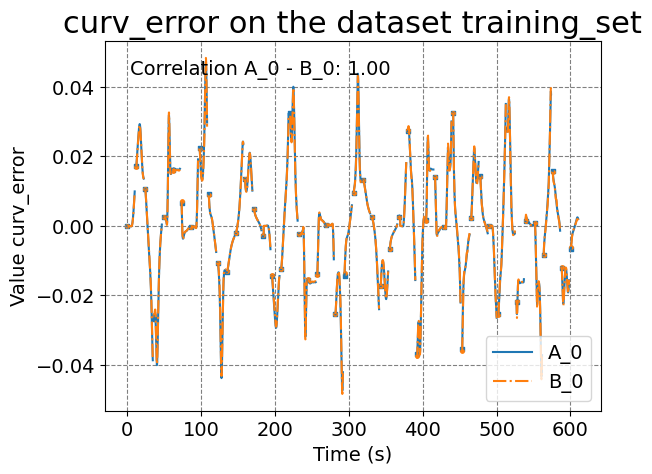

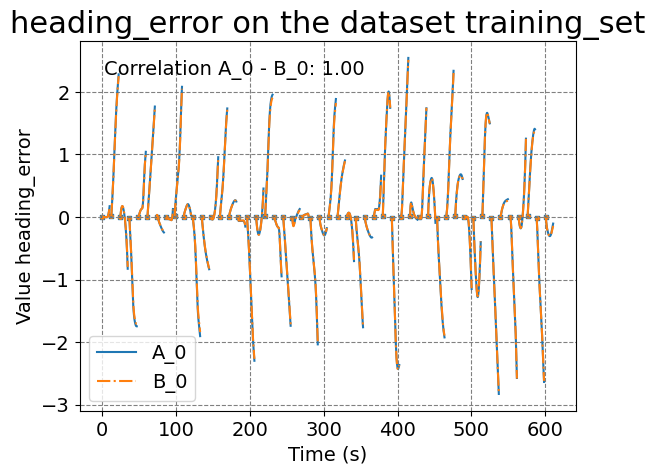

================= nnodely Model Results for validation_set ================
|     Loss    |        mse        |        FVU        |        AIC        |
|             |    small better   |    small better   |    lower better   |
|-------------------------------------------------------------------------|
|  curv_error |     7.635e-08     |     2.847e-04     |     1.087e+06     |
|heading_error|     1.553e-04     |     1.550e-04     |     1.092e+06     |
|-------------------------------------------------------------------------|
|    Total    |     7.771e-05     |     2.198e-04     |     1.089e+06     |
|-------------------------------------------------------------------------|


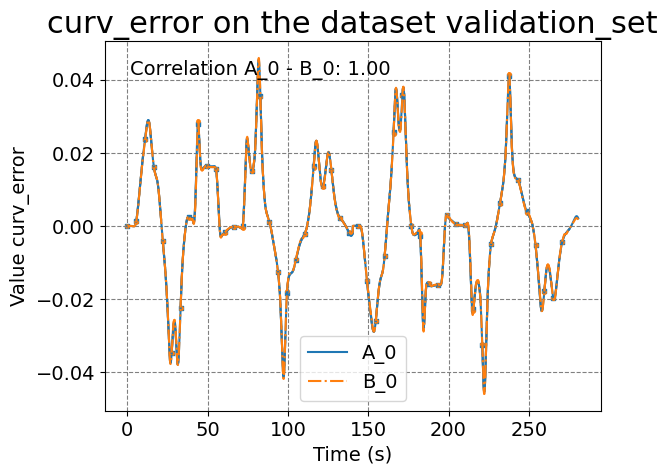

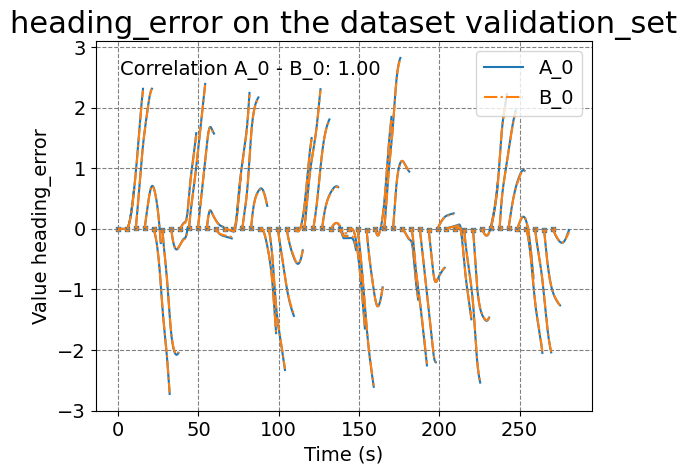

==================== nnodely Model Results for test_set ===================
|     Loss    |        mse        |        FVU        |        AIC        |
|             |    small better   |    small better   |    lower better   |
|-------------------------------------------------------------------------|
|  curv_error |     9.887e-08     |     4.011e-04     |     1.872e+05     |
|heading_error|     1.387e-04     |     1.989e-04     |     1.907e+05     |
|-------------------------------------------------------------------------|
|    Total    |     6.941e-05     |       3.e-04      |     1.889e+05     |
|-------------------------------------------------------------------------|


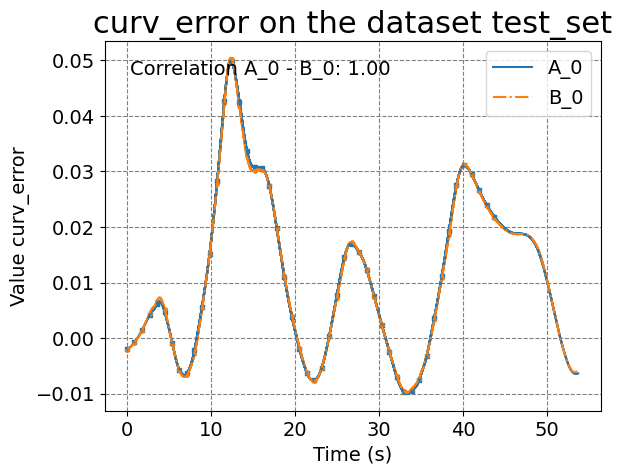

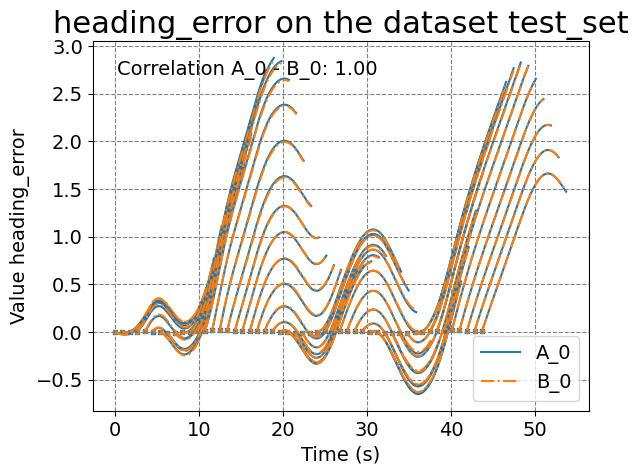

In [11]:
lat_dyna_model.analyzeModel('training_set',prediction_samples=200)      # 10 s prediction
lat_dyna_model.analyzeModel('validation_set',prediction_samples=200)
lat_dyna_model.analyzeModel('test_set',prediction_samples=200)

### Plot: curvature comparison

[__call__] Different number of samples between inputs [MAX 1105 = 1105; MIN 1076 = 1076]


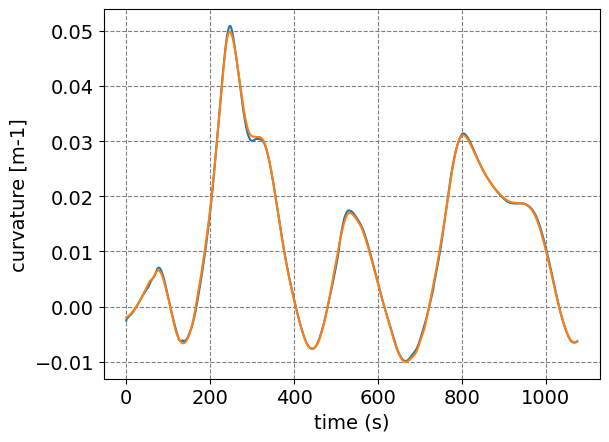

In [12]:
data = pd.read_csv("dataset/test/test_set.csv")

sample_test_set = {
    'model_steer_in': np.array(data['steer']),
    'model_vx_in' : np.array(data['vx']),
    'model_curv_in' : np.array(data['curv']),
    'model_ax_in' : np.array(data['ax'])
}

# Model inference
out_nn = lat_dyna_model(sample_test_set, sampled=False, prediction_samples=-1)

# Plot
plt.figure()
plt.plot(out_nn['model_curv'])
plt.plot(np.array(data['curv'])[30:])
plt.xlabel('time (s)')
plt.ylabel('curvature [m-1]')
plt.grid(True)

# SAVE MODEL

In [13]:
# Save json model: will be used in the controller training
lat_dyna_model.saveModel('vehicle_model')

=============================== Save JSON Model ================================
Model saved in:               trained_models/vehicle_model.json
